In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this project we are going to train a ML model to detect fake news based on Recurrent Neural Network. We will explot "Natural Language Processing (NLP)" to convert text into numbers. Theses numbers are then fed to train ML model (LSTM) for predicting the authenticity of news. The tasks performed in this project are:
* Exploratory data analysis
* Data cleaning
* Visualize datasets
* Prepare the data by performing tokenization and padding
* Train an LSTM Model
* Evaluate trained model performance

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
#Now keras libraries
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

In [ ]:
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

In [ ]:
fake_df

In [ ]:
true_df

In [ ]:
# Check null values True
true_df.isnull().sum()

In [ ]:
# Check null values of False
fake_df.isnull().sum()

In [ ]:
# If we also want to know the memory usage
fake_df.info()

In [ ]:
true_df.info()

## Exploratory Data Analysis

* Feature Engineering

In [ ]:
# Now lets add an target column for indicating real and fake news
true_df['isfake'] = 0
fake_df['isfake'] = 1

In [ ]:
true_df.head()

In [ ]:
fake_df.head()

In [ ]:
#Now lets concatenate both of them
df = pd.concat([true_df, fake_df]).reset_index(drop = True)
df

In [ ]:
# Drop the date column
df.drop(columns= ['date'], axis =1, inplace= True)
df

In [ ]:
# Combine "title" and "text" in single column
df['original'] = df['title'] + ' ' + df['text']
df.head()

In [ ]:
df['original'][0]

* Data Cleaning

In [ ]:
# Add some additional stopwors in nltk stopwords package
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
stop_words

In [ ]:
# To remove stopwords and words with length less than 3
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >3 and token not in stop_words:
            result.append(token)
    return result

In [ ]:
# Now lets apply the defined function of "original" text in our datadrame
df['clean'] = df['original'].apply(preprocess)

In [ ]:
df

In [ ]:
# original news
df['original'][0]

In [ ]:
# clean news after removing stopwords
print(df['clean'][0])

In [ ]:
# Total number of words in dataset
list_words = []
for i in df.clean:
    for j in i:
        list_words.append(j)
print ('Total number of words are: {}'.format(len(list_words)))

In [ ]:
#list_words

In [ ]:
#total unique words
total_unique_words = len(list(set(list_words)))
total_unique_words

In [ ]:
# Now lets convert words in "clean" column to a string
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df

Lets visualize one sample of each join_cleaned, cleaned and original column

In [ ]:
df['clean_joined'][1]

In [ ]:
print (df['clean'][1])

In [ ]:
print (df['original'][1])

Now its time to visualize the pre-processed dataset using some advance tools.

In [ ]:
# First, lets plot the num of samples in subject 
plt.figure(figsize=(8,8))
sns.countplot(y = 'subject', data = df)

In [ ]:
# fake vs true news
plt.figure(figsize=(8,8))
sns.countplot(y = 'isfake', data = df)

In [ ]:
# Now lets plot word cloud for Real news. This will show the most common words when the news is Fake.
plt.figure(figsize=(20,20))
wc = WordCloud(max_words= 2000, width= 1600, height= 800, stopwords= stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation= 'bilinear')

In [ ]:
# Now lets plot word cloud for Real news. This will show the most common words when the news is Fake.
# As most new are Political, so words are clearly visible in these plots.
plt.figure(figsize=(20,20))
wc = WordCloud(max_words= 2000, width= 1600, height= 800, stopwords= stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation= 'bilinear')

In [ ]:
# Now maximum length is required to create word embeddings
maxlen = -1
for news in df.clean_joined:
    tokens = nltk.word_tokenize(news) #converts text to tokens (words)
    if (maxlen < len(tokens)):
        maxlen = len(tokens)
print ("The maximum number of words in any news is =", maxlen)

In [ ]:
#Now lets visualize the distribution of number of words in a text, using a very interactive tool "Plotly"
import plotly.express as px
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

Now we will perform **Tokenization** and **Padding**

## **Tokenizer:** It allow us to covert text corpus into a sequence of integers.

In [ ]:
# Split data into Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2, random_state = 42)

In [ ]:
from nltk import word_tokenize

## To understand about "Keras Tokenizer" and the following commands in a more ellaborative way, please click [here](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do)

In [ ]:
# Lets create tokenizer to tokenize the words and conert them into a sequence
tokenizer = Tokenizer(num_words= total_unique_words)
tokenizer.fit_on_texts(x_train) #It creates vocabulary index ("word_index") based on word frequency
train_sequences = tokenizer.texts_to_sequences(x_train) # Replace each word in text with corresponding integer value from "word_index"
test_sequences = tokenizer.texts_to_sequences(x_test)

In [ ]:
len(train_sequences)

In [ ]:
len(test_sequences)

In [ ]:
print ("The encoding for news\n", df.clean_joined[0], "\n is\n :", train_sequences[0])

## Now we need to apply padding to make sure that all the sequences have same length.

In [ ]:
pad_train = pad_sequences(train_sequences, maxlen = 4405, padding = 'post', truncating= 'post')
pad_test = pad_sequences(test_sequences, maxlen=4405, padding = 'post', truncating= 'post')

In [ ]:
# Lets visualize the padding sequence for 1st two samples
for i, news in enumerate(pad_train[:2]):
    print("The padded encoding for news", i+1, " is : ", news)

In [ ]:
# Lets visualize the padding sequence for 1st two samples
for i, news in enumerate(pad_test[:2]):
    print("The padded encoding for news", i+1, " is : ", news)

## Recurrent Neural Networks (RNN)

* The major drawback of ANN is that they don't have time dependency or memory effect.
* RNN considers the temporal dimension and possess internal memory state.
* However, RNN suffers from ***Vanishing Gradient*** problem just like ANN. It fails to establish long term dependencies.

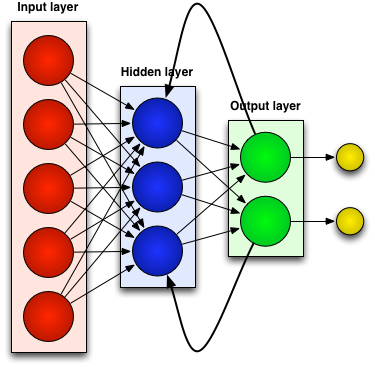

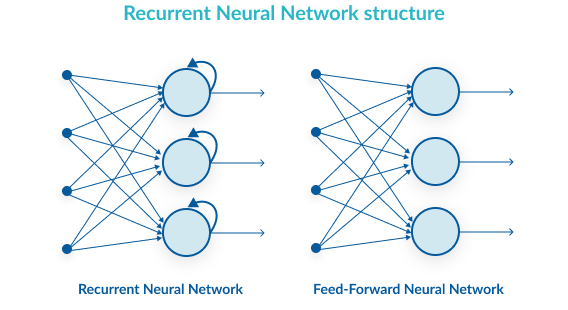Difference btw ANN & RNN

## Long Short Term Memory (LSTM)Networks

* LSTM works better as compared to RNN because it solves the vanishing gradient problem. All RNNs have feedback loops in the recurrent layer. This lets them maintain information in 'memory' over time. But, it can be difficult to train standard RNNs to solve problems that require learning long-term temporal dependencies. This is because the gradient of the loss function decays exponentially with time (called the vanishing gradient problem). LSTM networks are a type of RNN that uses special units in addition to standard units. LSTM units include a 'memory cell' that can maintain information in memory for long periods of time. A set of gates is used to control when information enters the memory, when it's output, and when it's forgotten. This architecture lets them learn longer-term dependencies. GRUs are similar to LSTMs, but use a simplified structure. They also use a set of gates to control the flow of information, but they don't use separate memory cells, and they use fewer gates. [Source](https://stats.stackexchange.com/questions/222584/difference-between-feedback-rnn-and-lstm-gru)

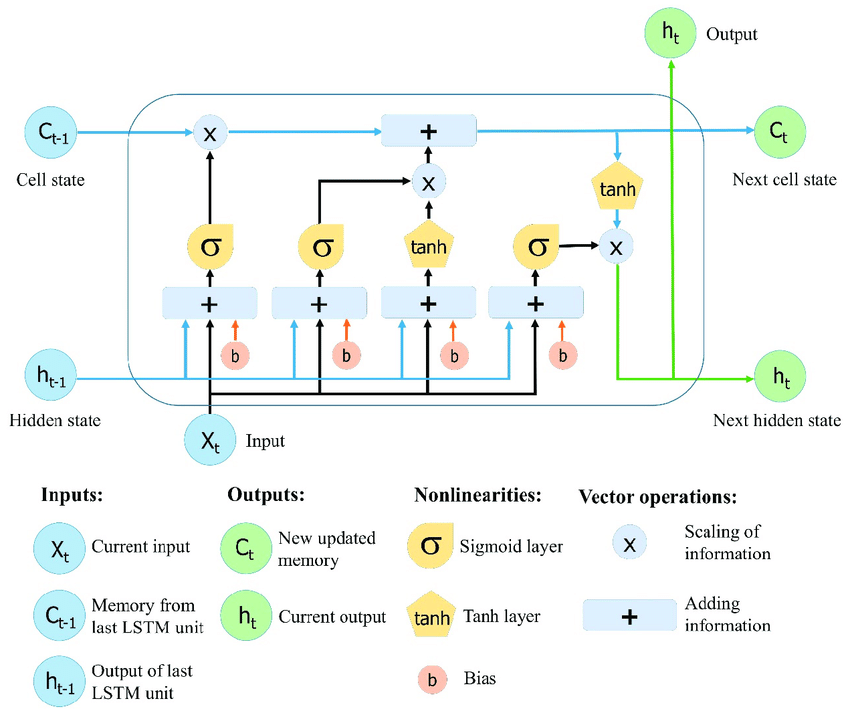

## Embedding Layers
* Embedding layers learn the low dimensional continuous representation of input discrete variables.
* Embedding layers can learn the ways to represent 10,000 variables with 200 variables (Just like PCA and Auto-encoders)
* Thus subsequent layer learn more efficiently with less compute resources.

In [ ]:
# Now lets build the model
model = Sequential() 

model.add(Embedding(total_unique_words, output_dim = 128)) #Embedding Layer

model.add(Bidirectional(LSTM(128))) #Bi-directional LSTM

#Dense layer
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) # binary classification (0\1)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['acc'])
model.summary()

In [ ]:
y_train = np.asarray(y_train)

In [ ]:
# train the model
model.fit(pad_train, y_train, batch_size= 64, validation_split = 0.1, epochs= 2)

## Assess Trained Model Performance

In [ ]:
pred = model.predict(pad_test) #prediction

In [ ]:
# Lets set the threshold 0.5, i.e if pred >0.5, it implies the news is fake and vice versa.
prediction = []
for i in range (len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [ ]:
#accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction)

print ("The model accuracy is :", accuracy)

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot = True)

## Acknowledgment

I am thankful to [Coursera](https://www.coursera.org/learn/nlp-fake-news-detector) and [Ryan Ahmad](https://www.coursera.org/instructor/~48777395) for providing an amazing opportunity for improving NLP skills.